In [1]:
# !pip install einops==0.8.0 wandb==0.17.9

## <span style='color:#ff5f27'> 📝 Imports</span>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial
from torch.utils.tensorboard import SummaryWriter

from functions.t5 import encode_text
from functions.vqgan import load_vqgan_model, load_process_encode_rgb_image, generate_iteration
from functions.utils import show_image
import config

2024-09-09 18:15:40,692 INFO: generated new fontManager


In [3]:
import wandb
wandb.login(key='287bb16bd939a26bd58a1fb72c38038e952d8e70')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/yarnapp/.netrc


True

## <span style='color:#ff5f27'> 🤖 Model Loading</span>

In [4]:
# Load COCO VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_COCO,
    config.VQGAN_CHECKPOINT_COCO,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-01-20T16-04-20_coco_transformer/coco_cond_stage.ckpt
2024-09-09 18:15:56,004 INFO: number of parameters: 6.513075e+08
Restored from logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> ⚙️ Text Encoding</span>

In [5]:
input_text = [
    config.PROMPT,
]

In [6]:
config.PROMPT

'A beautiful sunset over a city skyline.'

In [7]:
text_token_embeds, text_mask = encode_text(
    'A beautiful sunset over a city skyline.', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

torch.Size([39, 3, 1024])

In [8]:
text_token_embeds, text_mask = encode_text(
    'A cat sitting on the coutch', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

torch.Size([27, 3, 1024])

In [9]:
text_token_embeds, text_mask = encode_text(
    'Night rainy city', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

torch.Size([16, 3, 1024])

## <span style='color:#ff5f27'> 🗄️ Data Loader</span>

In [10]:
from functions.transistor import (
    TextImageDataset,
    collate_fn,
)

In [11]:
# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = TextImageDataset(
    json_file='mc_coco/annotations/captions_val2017.json', 
    img_dir='mc_coco/val2017', 
    transform=transform,
)

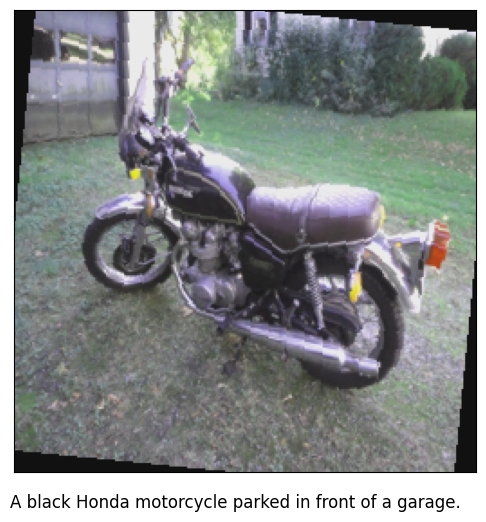

In [12]:
dataset.visualize_sample(0)

In [13]:
# Split the validation dataset into training and validation subsets
train_size = int(0.8 * len(dataset))  # Use 80% for training
val_size = len(dataset) - train_size  # Use 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

Total dataset size: 25014
Training set size: 20011
Validation set size: 5003


In [14]:
# from torch.utils.data import Subset

# # Define the size of the subset you want to use
# subset_size = 1000  # Change this to the number of images you want to use

# # Create a subset of the data
# subset_indices = torch.randperm(len(dataset))[:subset_size]
# subset_dataset = Subset(dataset, subset_indices)

# # Split the subset into training and validation
# train_size = int(0.8 * len(subset_dataset))
# val_size = len(subset_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(subset_dataset, [train_size, val_size])

# print(f"Full dataset size: {len(dataset)}")
# print(f"Subset size: {len(subset_dataset)}")
# print(f"Training set size: {len(train_dataset)}")
# print(f"Validation set size: {len(val_dataset)}")

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)



## <span style='color:#ff5f27'> 🧬 Transistor Architecture</span>

In [15]:
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F

In [16]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(Transistor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.layer_norm3 = nn.LayerNorm(hidden_dim // 2)
    
    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x1 = self.dropout(x1)
        x1 = self.layer_norm1(x1)
        
        x2 = F.relu(self.fc2(x1))
        x2 = self.dropout(x2)
        x2 = self.layer_norm2(x2)
        x2 = x1 + x2  # Skip connection
        
        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout(x3)
        x3 = self.layer_norm3(x3)
        
        return self.fc4(x3)

In [17]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [18]:
from torch.optim.lr_scheduler import _LRScheduler
import math 

class WarmupCosineSchedule(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, t_total, cycles=0.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            return [base_lr * (self.last_epoch / self.warmup_steps) for base_lr in self.base_lrs]
        else:
            progress = (self.last_epoch - self.warmup_steps) / (self.t_total - self.warmup_steps)
            return [base_lr * (0.5 * (1 + math.cos(math.pi * self.cycles * 2 * progress))) for base_lr in self.base_lrs]

## <span style='color:#ff5f27'> 🏃🏻‍♂️ Transistor Training</span>

In [19]:
@torch.no_grad()
def preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device):
    text_latents, _ = encode_text_fn(captions)
    text_latents = text_latents.mean(dim=1)  # Average over token dimension
    
    image_latents = []
    for img_path in img_paths:
        z, _ = load_process_encode_rgb_image(img_path, vqgan_model, device=device)
        image_latents.append(z.view(1, -1))  # Flatten to [1, 256*16*16]
    image_latents = torch.cat(image_latents, dim=0)
    return text_latents.to(device), image_latents.to(device)

@torch.no_grad()
def validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn):
    transistor_model.eval()
    total_loss = 0
    for captions, _, img_paths in val_loader:
        text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
        outputs = transistor_model(text_latents)
        loss = criterion(outputs, image_latents)
        total_loss += loss.item()
    return total_loss / len(val_loader)

In [20]:
def generate_image_from_text(user_query, transistor_model, vqgan_model, encode_text_fn, device, n_iterations=1):
    # Encode text
    text_latent, _ = encode_text_fn([user_query])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    c_code, _, [_, _, c_indices] = vqgan_model.first_stage_model.quantize(image_latent)
    
    print("c_code", c_code.shape, c_code.dtype)
    print("c_indices", c_indices.shape, c_indices.dtype)

    z_indices = torch.randint(256, c_indices.shape, device=vqgan_model.device)
    initial_image = vqgan_model.decode_to_img(z_indices, c_code.shape)

    print("Initial random image:")
    show_image(initial_image)

    for iteration in range(n_iterations):
        print(f"⛳️ Starting iteration {iteration + 1}/{n_iterations}")
        final_image = generate_iteration(
            vqgan_model, 
            c_code, 
            c_indices, 
            z_indices, 
            temperature=config.TEMPERATURE, 
            top_k=config.TOP_K, 
            update_every=config.UPDATE_EVERY,
            iteration=iteration,
        )

    print("✅ All iterations completed.")
    
    return final_image


In [21]:
# def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=10, accumulation_steps=4):
#     transistor_model.train()
#     scaler = torch.cuda.amp.GradScaler()
#     encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
#     writer = SummaryWriter()
    
#     best_val_loss = float('inf')
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
#         for i, (captions, _, img_paths) in enumerate(pbar):
#             text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
#             with torch.cuda.amp.autocast():
#                 outputs = transistor_model(text_latents)
#                 loss = criterion(outputs, image_latents)
            
#             scaler.scale(loss).backward()
            
#             if (i + 1) % accumulation_steps == 0:
#                 scaler.step(optimizer)
#                 scaler.update()
#                 optimizer.zero_grad(set_to_none=True)
            
#             running_loss += loss.item()
#             pbar.set_postfix({'loss': running_loss / (i + 1)})
        
#         avg_train_loss = running_loss / len(train_loader)
#         val_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)
        
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
#         writer.add_scalar('Loss/train', avg_train_loss, epoch)
#         writer.add_scalar('Loss/val', val_loss, epoch)
        
#         scheduler.step(val_loss)
        
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
#             print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
        
#         if (epoch + 1) % 5 == 0:
#             text = 'Beautiful green forest with a lot of green trees'
#             generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text_fn, device)
    
#     writer.close()
#     print("✅ Training completed.")

In [22]:
def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=25, accumulation_steps=1):
    wandb.init(project="text-to-image-transistor", config={
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "accumulation_steps": accumulation_steps
    })
    
    transistor_model.train()
    scaler = torch.cuda.amp.GradScaler()
    encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    
    total_steps = num_epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=0.001, total_steps=total_steps, pct_start=0.3)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, (captions, _, img_paths) in enumerate(pbar):
            text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
            with torch.cuda.amp.autocast():
                outputs = transistor_model(text_latents)
                loss = criterion(outputs, image_latents)
            
            scaler.scale(loss).backward()
            
            torch.nn.utils.clip_grad_norm_(transistor_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
                
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i + 1)})
            
        avg_train_loss = running_loss / len(train_loader)
        val_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
            print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
            
        if (epoch + 1) % 5 == 0:
            text = 'Beautiful green forest with a lot of green trees'
            generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text_fn, device)
            wandb.log({"generated_image": wandb.Image(generated_image)})
            
    wandb.finish()
    print("✅ Training completed.")

In [23]:
# Initialize Transistor model
input_dim = 1024  # Dimension of T5 output
hidden_dim = 2048
output_dim = 256 * 16 * 16
transistor_model = Transistor(input_dim, hidden_dim, output_dim, dropout_rate=0.2).to(config.DEVICE)

In [24]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(transistor_model.parameters(), lr=0.0005, weight_decay=0.01)

🕰️ Time: 16.21 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


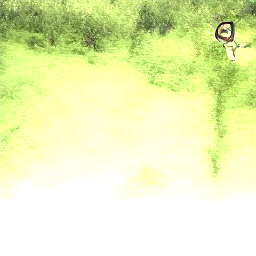

✅ All iterations completed.


Epoch 12/25:  69%|██████▉   | 866/1251 [25:20<11:02,  1.72s/it, loss=0.595]

In [ ]:
# Train the model
train_model(
    transistor_model, 
    train_loader, 
    val_loader, 
    vqgan_model, 
    criterion,
    optimizer,
    config.DEVICE, 
    num_epochs=25, 
    accumulation_steps=1,
)

## <span style='color:#ff5f27'> 🗄️ Transistor Loading</span>

In [32]:
def load_transistor_model(model_path):
    # Define model parameters
    input_dim = 1024  # Dimension of T5 output
    hidden_dim = 2048
    output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space

    # Create model instance
    transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

    # Load the saved state dictionary
    transistor_model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    transistor_model.eval()

    return transistor_model

# Usage
transistor_model = load_transistor_model('best_transistor_model.pth')

🕰️ Time: 16.71 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


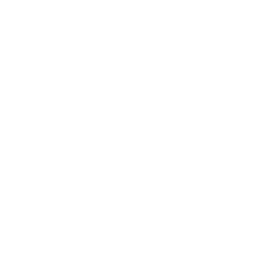

✅ All iterations completed.


In [45]:
text = 'Beautifull green forest with a lot of green trees'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE, n_iterations=3)

🕰️ Time: 16.48 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


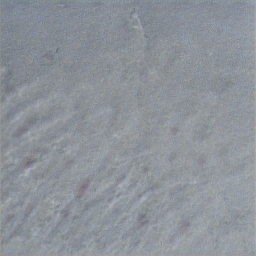

✅ All iterations completed.


In [34]:
text = 'Blue Ocean with blue waves'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE, n_iterations=3)

🕰️ Time: 16.45 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


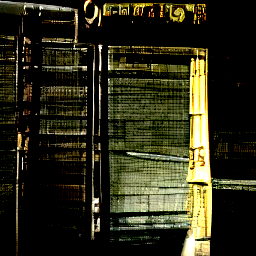

✅ All iterations completed.


In [35]:
text = 'Yellow beautiful flower'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE, n_iterations=3)

🕰️ Time: 16.67 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


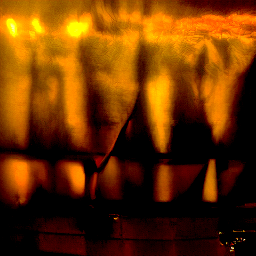

✅ All iterations completed.


In [41]:
text = 'Red Car'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE, n_iterations=3)

---

🕰️ Time: 16.70 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


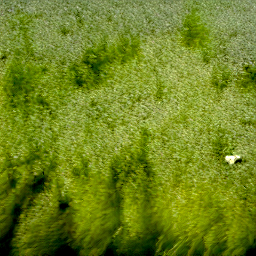

✅ All iterations completed.


In [100]:
text = 'Beautifull green forest with a lot of green trees'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.42 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


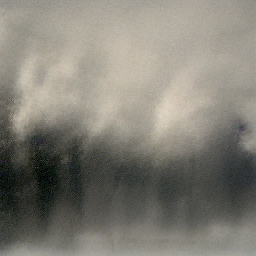

✅ All iterations completed.


In [101]:
text = 'Blue ocean with blue waves'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.56 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


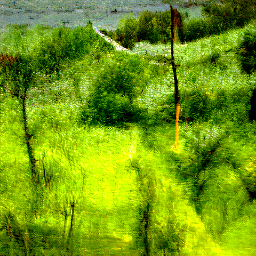

✅ All iterations completed.


In [102]:
text = 'Yellow beautiful flower'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

---